## Statistical analysis of GaAs/GaInP photocathodes from multiple growths and across each growth

**Authors:**
> Olivia Alley, (oalley@lbl.gov), [github](https://github.com/oliviaalley)  
> Joel W. Ager (jwager@lbl.gov), [Group website](http://ager.mse.berkeley.edu), [github](https://github.com/joelager)



**Resources**  
* Package `eclabfiles` reads files written by EC-Lab, installed with `pip install eclabfiles` 
  * [link](https://pypi.org/project/eclabfiles/), version 0.4.1 - it was not on `pypi` at one point but now it is...
  * Also, it requires `python` version >= 3.9

## Analysis 1:  
### Box plots for 2 electrode results for each of 8 growths with Jsat, V(5mA), and Jsc. Compare this with box plot for entire data set of 54 electrodes over 8 growths.

> Area of each electrode = 0.2 cm2  
> What materials were each? what were the parameters changed between growth? i.e. capping layer  
> Total number of 2 electrode cuvette results at pH 0.4: 54  
> Total number of MOVPE growths represented: 8  
> Between 2 and 10 electrodes per wafer

## Import eclab LSV files and extract data and metadata

Imports all columns of each eclab file using the ecf.process method.  
The eclabfiles parser may not still be maintained as of 2022.
    
>.mpr files will be used here.
All cuvette data was collected in 30-305 and under 1 sun illumination--therefore there is no need to accomodate .mpt files, which are needed for analysis of 30-107 data.

>Some options for values to calculate incldude the 2-electrode saturation photocurrent (Jsat) or zero bias photocurrent (Jsc), and the applied potential for 5 mA/cm2 current density.

   **File naming convention:**

        LSV files: WB832-1_0pt5MH2SO4_3e-1_LSV.mpr
        During acquisition can add as comments additional metadata

        Surface area file: SA.xlsx
        
note WB832-1r is a repeat measurement of the same electrode

In [2]:
# file handling
import os
import eclabfiles as ecf

# data analysis
import pandas as pd
import numpy as np
import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Generate file and sample lists

In [9]:
# Collect all files and iterate through them, making a list of their names for later reference

# change directory_in_str to match where the .mpr files are
directory_in_str = './H2SO4 electrolyte/2e'
filename_list = []
electrode_list = []

# This function generates a byte string, which can be referenced like a list
# each character except for quotes becomes a value. This function uses UTF-8 encoding to generate the bytes.
directory = os.fsencode(directory_in_str)

# generate list of full names and of their prefix prior to the first '_'
# from naming convention, prefix is electrode name, for example WB832-5.
for file in os.listdir(directory):
     filename = os.fsdecode(file)
     if filename.endswith(".mpr"):
        filename_list.append(filename)
        #print(format(filename))
        name,ext = os.path.splitext(filename)
        #print(name)
        # add the filename to a list
        electrode_list.append(name.split('_', maxsplit=1)[0])
        #print(name[:7])
        continue
     else:
         continue

# read in the SA.xlsx file in the main folder
# could use concat to merge df_SA and the two lists above on 'Electrode' to facilitate accessing SA later
df_SA = pd.read_excel('./H2SO4 electrolyte/SA.xlsx')
print("Electrode surface areas from file:\n", df_SA.head(10))
            
# <40 to get a minimum length of 40 and left justified. {"*"*60} to add a row of *
print("\nList of all files loaded here:")
print(f'{"Filename":<40}\tElectrode\n{"*"*60}')
for filename, electrode in zip(filename_list, electrode_list):
    print(f'{filename:<40}\t{electrode}')

Electrode surface areas from file:
    Electrode  surface area (cm2) Growth  Unnamed: 3 Unnamed: 4
0   WB832-C1            0.118727  WB832         NaN        NaN
1   WB832-C2            0.131000  WB832         NaN        NaN
2   WB832-C3            0.116000  WB832         NaN        NaN
3   WB832-C4            0.094000  WB832         NaN        NaN
4   WB832-C5            0.095000  WB832         NaN        NaN
5   WB832-C6            0.093000  WB832         NaN        NaN
6   WB832-C7            0.109000  WB832         NaN        NaN
7   WB832-C8            0.096000  WB832         NaN        NaN
8   WB832-C9            0.098000  WB832         NaN        NaN
9  WB832-C10            0.111000  WB832         NaN        NaN

List of all files loaded here:
Filename                                	Electrode
************************************************************
WB832-C1_0pt5MH2SO4_2e_LSV.mpr          	WB832-C1
WB832-C2_0pt5MH2SO4_2e_LSV.mpr          	WB832-C2
WB832-C3_0pt5MH2SO4_2e_LSV.

# Define the functions to operate on the data

In [10]:
# Edit the column names based on those needed for analysis
# no longer used
def column_edit(df):
    """
    Can select desired columns depending on the experiment.
    Input: a dataframe from eclabfiles.read
    Output: None, acts in place on the input
    """
    # drop the columns you don't want
    df.drop(['time', '(Q-Qo)', 'I Range', 'mode', 'ox/red', 'error', 'control changes', 'uts'], axis=1, inplace=True)
    # rename the columns you do want
    df.rename(columns={'control_V': 'Control (V)', 'Ewe': 'Ewe (V vs. CE)', '<I>': 'I (mA)'}, inplace=True)
    #print("column_edit:", df.head(1))
    
# Find the surface area for each sample in the surface area file, and use it to calculate the current density
def J_calc(df, electrode):
    """
    Inputs:
      dataframe from ec.to_df, string with the sample name
    Outputs
      None, acts in place on the dataframe
    """
    # Search df_SA for electrode to get the surface area in the row.
    name_index = df_SA.index[df_SA['Electrode'] == electrode]
    #print('the row is: \n', df_SA.iloc[name_index])
    #print('printing the value in the row with the right name: ', df_SA.iloc[name_index]['surface area (cm2)'].iloc[0])
    elec_SA = df_SA.iloc[name_index]['surface area (cm2)']
    #print('the surface area is: ', elec_SA.iloc[0])
    current_density = df['I (mA)'].div(elec_SA.iloc[0])
    df['J (mA/cm2)'] = current_density
 #   print('after J_calc: \n', df.head(1))
    
# Calculate the saturation current density and return it to the calling function
def Jsat_calc(df):
    """
    Calculates saturation current density assuming that corresponds to the most negative applied potential.
    Input:
     dataframe from ec.to_df
    Output:
     the saturation current density
    """
    mindex = df.index[df['Ewe (V vs. CE)'] == df['Ewe (V vs. CE)'].min()]
    sat_photocurrent = df.iloc[mindex]['J (mA/cm2)']
   # print("after Jsat_calc:", sat_photocurrent.iloc[0])
    return sat_photocurrent.iloc[0]

# Calculate the photocurrent at zero bias for two electrode LSVs
# Bias is never exactly zero: goes from -4.9314409E-004 V to 4.9910863E-004 V.
# Take average photocurrent of the points straddeling zero
# find index by looking for voltages greater than 0 and then subtract 1 from the first of them
def zero_bias(df):
    """
    Input: data frame
    Output: the short circuit current of the LSV in the data frame
    """
    # First, check if there is anything over zero. If not, sample failed, should enter 0 as zero bias current.
    #print('initial_df:', df.head())
    if df[df['Control (V)']>0].empty:
        print("electrode failed at zero V")
        return 0
    else:
        over_zero_df = df[df['Control (V)']>0]
        under_zero_df = df[df['Control (V)']<0]
        length = len(under_zero_df['Control (V)'])
    #    print("length:", length)
    #    print('under_zero_df:', under_zero_df.head())
    #    print("first J(mA/cm2) of over_zero:", over_zero_df.iloc[0]["J (mA/cm2)"])
   #     print("last J of under_zero:", under_zero_df.iloc[length-1]["J (mA/cm2)"])
        #under_zero_df.head(5)
        #zerodex = over_zero_df.tail(1).index
        #print("index for zero potential:", zerodex[0] - 1)
        #zero_bias_index = zerodex[0] - 1
        #print('first index for zero bias average:', zero_bias_index)
        #print(full_df)
        # Now just average the current density at the smallest positive and negative biases to approximate the bias at zero V
        Jsc = (under_zero_df.iloc[length-1]["J (mA/cm2)"] + over_zero_df.iloc[0]["J (mA/cm2)"])/2
        #Jsc = (df.iloc[zero_bias_index]['J (mA/cm2)'] + df.iloc[zero_bias_index - 1]['J (mA/cm2)'])/2
      #  print('The short circuit current density (mA/cm2) is: ', Jsc)
        return Jsc

# Calculate the lowest potential generating 5 mA/cm2 photocurrent.
def five_mA_pot(df):
    """
    calculate the lowest potential generating 5 mA/cm2 photocurrent.
    then find the most positive bias which is applied within that set.
    Input: a dataframe
    Output: float with the answer
    """
    if df[df['J (mA/cm2)']<-5].empty:
        print("electrode did not reach 5mA/cm2.")
        return 0
    else:
     #   print('whole df:', df.head())
        first_df = df[df['J (mA/cm2)']<-5]
     #   print('five mA calc first_df:', first_df.head())
    # what to do if first_df is empty?
        second_df = first_df[first_df['Control (V)'] == first_df['Control (V)'].max()]
    # The type of the single row df second_df is a Pandas series:
    #print(type(second_df['Control (V)']))
    # provide the value of the series in the Control (V) column.
        five_V = second_df['Control (V)'].iloc[0]
     #   print('The maximum potential (in V vs. CE) giving at least 5 mA/cm2 is: ' , five_V)
        return five_V

def row_del(df, row_list):
    """
    Intent is to facilitate plotting by removing first <int> rows
    Input: original LSV dataframe
    Output: acts in place on df
    """
    df.drop(row_list, inplace=True)
  #  print("with dropped rows:", df.head(1))

In [11]:
filename = 'WB832-1_0pt5MH2SO4_2e_LSV.mpr'
temp = filename.split('.')[0].split('_')
print(temp)
print("electrode name is:", temp[0])
print("electrolyte is:", temp[1])
print("geometry is:", temp[2])
print("measurement is:", temp[3])
print("growth is:", temp[0].split('-')[0])

['WB832-1', '0pt5MH2SO4', '2e', 'LSV']
electrode name is: WB832-1
electrolyte is: 0pt5MH2SO4
geometry is: 2e
measurement is: LSV
growth is: WB832


In [12]:
filename = 'WB832-1_0pt5MH2SO4_2e_LSV.mpr'
temp = filename.split('.')[0].split('_')
print(temp)
growth = temp[0].split('-')[0]
temp.append(growth)
print(temp)
print("electrode name:", temp[0])
print("electrolyte:", temp[1])
print("geometry:", temp[2])
print("measurement:", temp[3])
print("growth:", temp[4])

['WB832-1', '0pt5MH2SO4', '2e', 'LSV']
['WB832-1', '0pt5MH2SO4', '2e', 'LSV', 'WB832']
electrode name: WB832-1
electrolyte: 0pt5MH2SO4
geometry: 2e
measurement: LSV
growth: WB832


In [13]:
# Parse the prefix
# filename: WB832-1_0pt5MH2SO4_3e-1_LSV.mpr
def parse_filename(filename):
    """
    Parse the naming convention used by Olivia
    Input: prefix string
    Output: list with name of sample, experimental geometry, type of measurements
    """
    temp = filename.split('.')[0].split('_')
    growth = temp[0].split('-')[0]
    temp.append(growth)
    #print(temp)
    # Some crude error checking
    if len(temp) >= 5:
        tokens = temp[0:5]   #Truncate if too long
    elif len(temp) == 3:
        tokens = [temp[0], temp[1], temp[2], 'N/A']
    elif len(temp) == 2:
        tokens = [temp[0], temp[1], 'N/A', 'N/A']
    elif len(temp) == 1:
        tokens = [temp[0], 'N/A', 'N/A', 'N/A']
    else:
        tokens = ['N/A', 'N/A', 'N/A', 'N/A']
    # if some are missing, it there a better way than having the remaining ones here in random order?
    return tokens

In [14]:
#i = 0
#for e in exp_list:
#    print("sample no.:", i, e["sample"])
#    i = i + 1

# Read files in and construct data object

In [15]:
exp_list = []

for filename in filename_list:     # Note that I am not using prefix_list
    """
    This loop generates a list of dictionarie
    The data (poential, current, etc.) is in dataframe called 'data'
     For the dataframe, using same column headings as Olivia
    Metadata, including sample name, is other (key, value) pairs
      Much more information could be added, e.g. time of measurement in date-time format
    """
    raw_data, meta = ecf.process(directory_in_str + '/' + filename)
    exp_list.append({"sample": parse_filename(filename)[0],
                     "electrolyte": parse_filename(filename)[1],
                     "geometry": parse_filename(filename)[2],
                     "measurement": parse_filename(filename)[3],
                     "growth": parse_filename(filename)[4],
                     # put the data of interest into a dataframe
                     "data": pd.DataFrame({'time': [dic['time'] for dic in raw_data],
                                          'Ewe (V vs. CE)':  [dic['Ewe'] for dic in raw_data],
                                           'Control (V)': [dic['control_V'] for dic in raw_data], 
                                          'I (mA)':  [dic['<I>'] for dic in raw_data]}),
                     'reference electrode': meta['settings']['reference_electrode'],
                     'dE/dt': meta['params'][0]['dE/dt'],
                     'full path': meta['log']['filename'],
                     'posix_timestamp': meta['log']['posix_timestamp'], 
                     # Can convert to date-time
                     "date": datetime.datetime.fromtimestamp(meta['log']['posix_timestamp']),
                     "meta": meta,
                     "raw_data": raw_data})


In [16]:
# Sort the list by sample
sort_helper = lambda dic: dic["sample"]   # Use a quick lambda function to extract sample. sort_helper takes in dic and returns dic["sample"]
# list.sort() has a key parameter to specify a function to be called on each list element prior to making comparisons
exp_list.sort(key=sort_helper)

growth_list = []
sample_list = []
for exp in exp_list:
  #  print("exp_list growths:", exp['growth'])
    growth_list.append(exp['growth'])
    sample_list.append(exp['sample'])
print(set(growth_list))

#print("exp_list keys:", exp_list[1].keys())

# Run Olivia's functions and add columns to dataframe and (key, value) entries to the dictionary
for exp in exp_list:
    
    #print("sample name:", parse_filename(filename)[0])
    print("sample name:", exp["sample"])
    
    # Add and calculate a new column called "J (mA/cm2)" to the dataframe
    # the function changes each element of exp_list to include the new column
    J_calc(exp['data'], exp['sample'])
    
    # Remove first two data points to prevent plotting issue
    # this function acts on each element of exp_list, changing it
    row_del(exp['data'], [0,1])

    # Run Olivia's functions and add columns to dataframe and (key, value) entries to the dictionary
    # This one returns the saturation current density
    # I will add it to the dictionary
    # Jsat_calc will return the value of the saturation current density for this element of the exp_list.
    # This creates a new key in the exp_list[i] (where i = any list index) containing Jsat corresponding to each experiment.
    exp["Jsat (mA/cm2)"] =  Jsat_calc(exp['data'])
    
    # J at zero bias, added to dictionary
    # creates a new key in exp_list[i] for zero bias current
    exp["zero bias"] =  zero_bias(exp['data'])

    # 5 mA potential, added to dictionary
    # creates a new key in exp_list[i] for potential at 5mA/cm2
    exp["5 mA potential"] =  five_mA_pot(exp['data'])
    
# check that the right keys were created for one of the electrodes
# later make it a random electrode checked each time
print("exp_list keys:", exp_list[1].keys())

{'WB909', 'WC134', 'WC213', 'WC138', 'WB964', 'WB832', 'WC109', 'WC009'}
sample name: WB832-C1
sample name: WB832-C2
electrode failed at zero V
sample name: WB832-C3
sample name: WB832-C4
sample name: WB832-C5
sample name: WB832-C6
sample name: WB832-C7
sample name: WB832-C8
sample name: WB832-C9
sample name: WB832-NREL2
sample name: WB832-NREL3
sample name: WB832-NREL4
sample name: WB832-NREL5
sample name: WB832-NREL8
sample name: WB909-1
electrode failed at zero V
electrode did not reach 5mA/cm2.
sample name: WB909-2
sample name: WB909-3
sample name: WB909-4
sample name: WB909-5
sample name: WB909-6
sample name: WB909-7
electrode failed at zero V
sample name: WB964-10
electrode failed at zero V
electrode did not reach 5mA/cm2.
sample name: WB964-2
sample name: WB964-4
sample name: WB964-6
electrode failed at zero V
sample name: WB964-8
sample name: WC009-1
electrode failed at zero V
sample name: WC009-2
sample name: WC009-3
sample name: WC009-4
sample name: WC009-5
sample name: WC009

In [17]:
#print(exp_list[0])

In [12]:
# now, data is all added to data structure.

In [18]:
# When were the measurements?

print('Sample     Measurement date and time')
for exp in exp_list:
    """
    The <10 in the format string makes a minimum length of 10 and left justifies
    """
    print(f"{exp['sample']:<10} {exp['date']:%Y-%m-%d %H:%M}" )

Sample     Measurement date and time
WB832-C1   2021-07-05 21:21
WB832-C2   2021-07-05 15:23
WB832-C3   2021-07-05 21:14
WB832-C4   2021-07-05 15:39
WB832-C5   2021-07-05 21:06
WB832-C6   2021-07-05 15:52
WB832-C7   2021-07-05 20:58
WB832-C8   2021-07-05 16:00
WB832-C9   2021-07-05 20:49
WB832-NREL2 2021-07-15 14:21
WB832-NREL3 2021-07-15 12:17
WB832-NREL4 2021-07-15 14:09
WB832-NREL5 2021-07-15 14:35
WB832-NREL8 2021-07-15 13:54
WB909-1    2021-07-19 12:33
WB909-2    2021-07-27 12:36
WB909-3    2021-07-19 13:01
WB909-4    2021-07-27 12:53
WB909-5    2021-07-23 11:30
WB909-6    2021-07-27 13:08
WB909-7    2021-07-23 11:47
WB964-10   2021-07-23 12:57
WB964-2    2021-07-23 12:32
WB964-4    2021-07-23 13:21
WB964-6    2021-07-23 12:13
WB964-8    2021-07-23 13:08
WC009-1    2021-11-09 17:06
WC009-2    2021-11-08 17:41
WC009-3    2021-11-09 17:31
WC009-4    2021-11-08 17:34
WC009-5    2021-11-09 17:25
WC009-6    2021-11-08 17:15
WC009-7    2021-11-09 17:38
WC009-8    2021-11-08 17:25
WC009-

# Plot LSVs

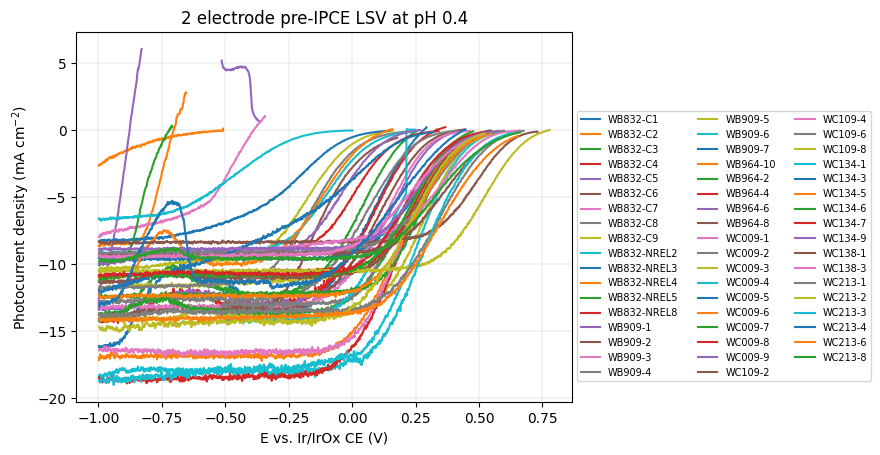

In [19]:
# Plot LSVs using matplotlib.pyplot
# should incorporate reference electrode look up here
# do this for each growth

for dic in exp_list:
    # Using points here because there are values which return to the start
    # deleted first two rows so that is no longer a problem
    plt.plot(dic['data']['Ewe (V vs. CE)'], dic['data']["J (mA/cm2)"], '-', ms=1.5,  
             label=dic['sample'])
# Fancy, get the sweep rate from the metadata (assuming all were done at the same rate, which is a good assumption)
plt.title(f"2 electrode pre-IPCE LSV at pH 0.4")
#plt.title(f"LSVs at {dic['dE/dt']:.0f} mV/s")
plt.xlabel(f"E vs. Ir/IrOx CE (V)")
#plt.xlabel(f"E vs. CE (V)")
plt.ylabel("Photocurrent density (mA cm$^{-2}$)")
plt.legend(bbox_to_anchor=(1, .8), ncol=3, fontsize=7)
plt.grid(lw=0.2)
plt.show()

Axes(0.125,0.653529;0.227941x0.226471)
Axes(0.398529,0.653529;0.227941x0.226471)
Axes(0.672059,0.653529;0.227941x0.226471)
Axes(0.125,0.381765;0.227941x0.226471)
Axes(0.398529,0.381765;0.227941x0.226471)
Axes(0.672059,0.381765;0.227941x0.226471)
Axes(0.125,0.11;0.227941x0.226471)
Axes(0.398529,0.11;0.227941x0.226471)
Axes(0.672059,0.11;0.227941x0.226471)


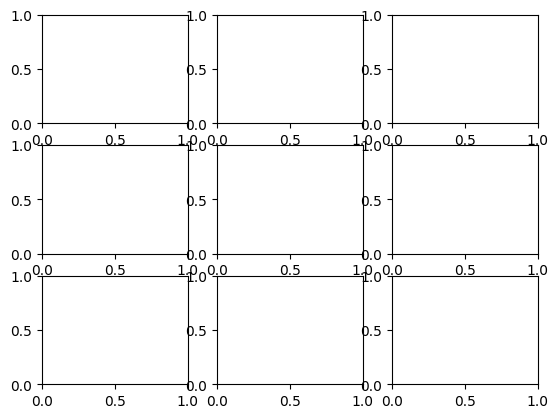

In [20]:
# a way to directly address the three columns
fig, ax = plt.subplots(nrows=3, ncols=3)
for a in ax:
    for i in range(0,3):
        print(a[i])
plt.show()

## LSV plotted for each growth
 what does zip do? requires two equal length lists and zips them together into an equal number of tuples
#for lat, long in zip(Latitudes, Longitudes):
    print(lat, long)
 For each growth, use one axes.
 for each exp, plot on the axes corresponding to the growth
 Title of each axes will be the growth. How to automate this? first count the number of growth values by one iteration, and give each axes a title and identity.
 create a dataframe with growth, axes[i] values to refer to
 legend will be the electrodes
 can go back an plot on the same axes again? I think so
 Iterate through exp_list. 

 now, have growth_list and set(growth_list), the latter which contains only the unique values of exp_list['growth']
#print(growth_list)
#print(set(growth_list))

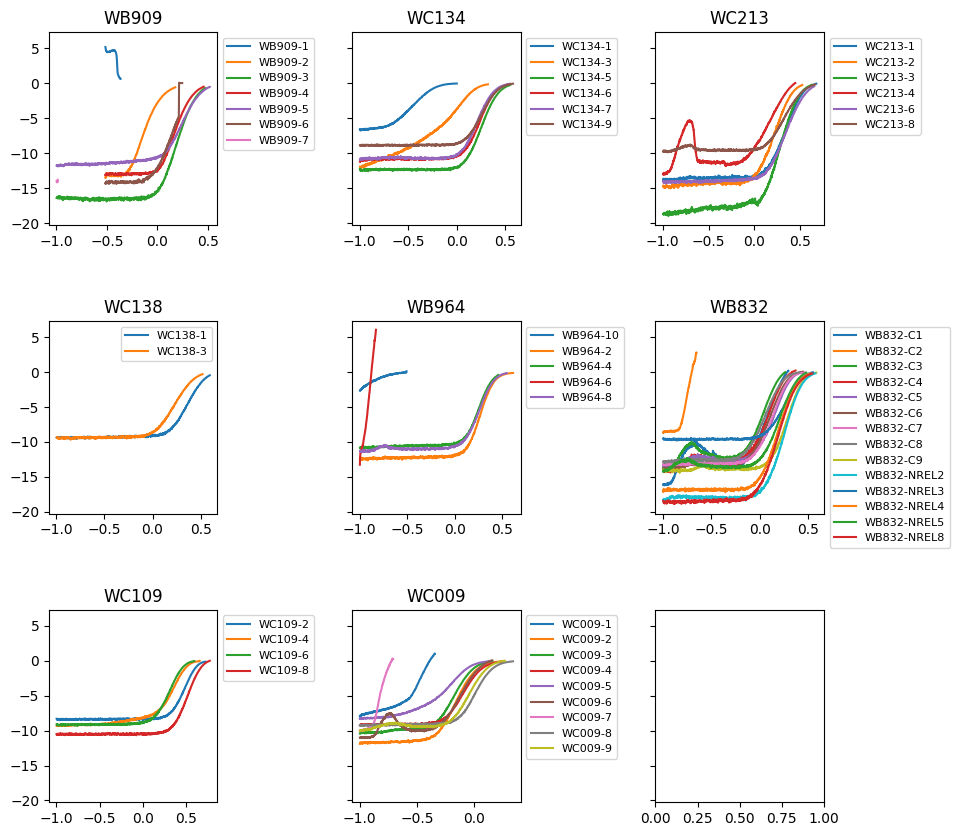

In [29]:
#fig, ax = plt.subplots(nrows=8, ncols=1, sharey=True, dpi=100, figsize=(6, 20))
fig, ax = plt.subplots(nrows=3, ncols=3, sharey=True, dpi=100, figsize=(10, 10))
# make a list to refer to each element in the 3x3 plot array
ax_list = []
for a in ax:
    for i in range(0,3):
        #print(a[i])
        ax_list.append(a[i])
#print(ax_list)
for growth, axes in zip(set(growth_list), ax_list):
    axes.set_title(growth)
    # Now iterate through the experiment list and plot the electrodes corresponding to this growth.
    for exp in exp_list:
        if exp['growth']==growth:
            # it is from the same growth
            axes.plot(exp['data']['Ewe (V vs. CE)'], exp['data']['J (mA/cm2)'], '-', ms=1.5, 
                      label=exp['sample'])
            axes.legend(bbox_to_anchor=(1,1), fontsize=8, ncol=1)
        else:
            continue

# add some white space
fig.subplots_adjust(wspace=.8, hspace=0.5)

plt.show()

## Display and statistical analysis of device parameters

In [43]:
# Add the electrode summary data (Jsc etc) to a dataframe

sample = []
growth = []
Jsat = []
Jsc = []
V_5mA = []

for exp in exp_list:
    """
    The <10 in the format string makes a minimum length of 10 and right justifies
    """
    sample.append(exp['sample'])
    growth.append(exp['growth'])
    Jsat.append(np.abs(exp['Jsat (mA/cm2)']))
    Jsc.append(np.abs(exp['zero bias']))
    V_5mA.append(float(exp['5 mA potential']))
    
df_all = pd.DataFrame({'Sample': sample,
                       'Growth': growth,
                       'Jsat (mA/cm2)': Jsat,
                       'Jsc (mA/cm2)': Jsc,
                       'V_5mA (V)': V_5mA})

df_all.head()

,Sample,Growth,Jsat (mA/cm2),Jsc (mA/cm2),V_5mA (V)
0,WB832-C1,WB832,16.157954,9.104689,0.106404
1,WB832-C2,WB832,8.573917,0.000000,-0.773122
2,WB832-C3,WB832,13.652918,7.169919,0.057431
3,WB832-C4,WB832,14.090213,9.204426,0.116999
4,WB832-C5,WB832,13.410872,10.437638,0.179965


<Axes: xlabel='Growth', ylabel='V_5mA (V)'>

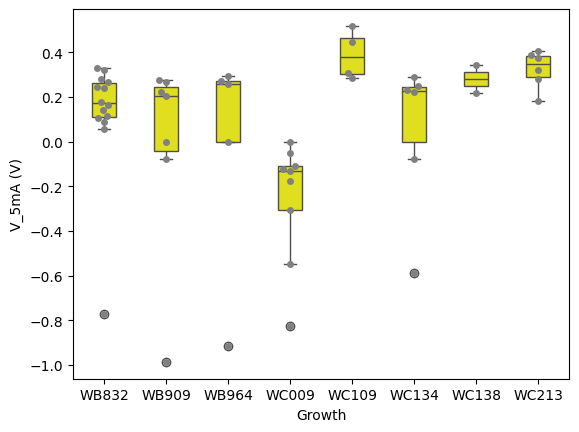

In [43]:
# playing with boxplots
sns.boxplot(y='V_5mA (V)', data=df_all, x='Growth', width = 0.4, color = 'yellow', zorder=2)
sns.swarmplot(y='V_5mA (V)', data=df_all, x='Growth', color='gray')

## Box plots of each growth vs. entire set
### The selected parameters (Jsat, Jsc, and V_5mA) are compared visually between electrodes from each wafer and all electrodes measured:

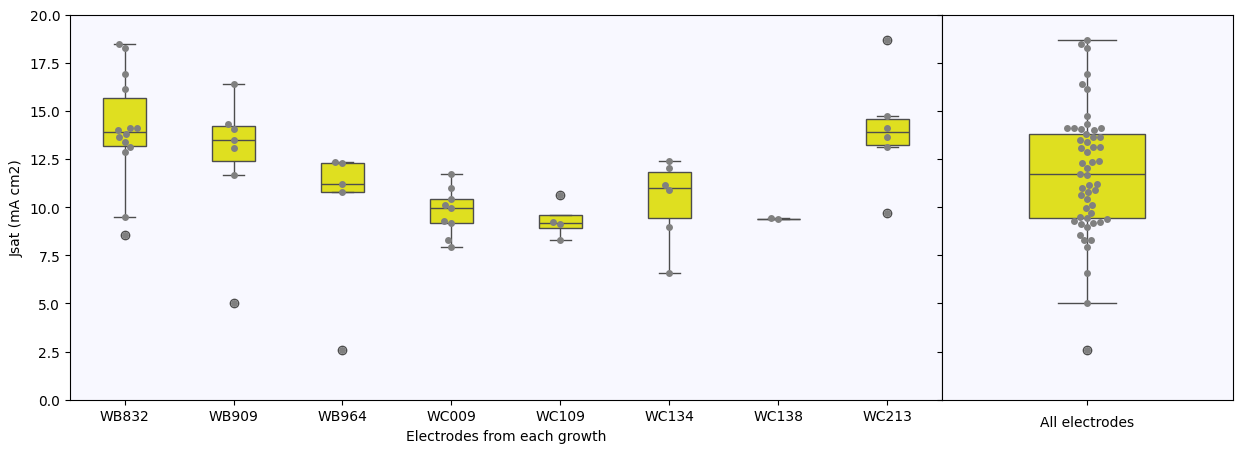

In [44]:
# Can divide it up by growth during the plotting process, no need for a separation or grouping
# Compare saturation current for each electrode and all electrodes

fig, ax = plt.subplots(nrows=1, ncols=2, dpi=100, sharey=True, figsize=(15,5), gridspec_kw={'width_ratios': [3, 1]})

sns.boxplot(y='Jsat (mA/cm2)', data=df_all, x='Growth', width = 0.4, ax=ax[0], color = 'yellow', zorder=2)
sns.swarmplot(y='Jsat (mA/cm2)', data=df_all, x='Growth', ax=ax[0], size=5, color='gray')

sns.boxplot(y='Jsat (mA/cm2)', data=df_all, width=0.4, ax=ax[1], color='yellow', zorder=2)
sns.swarmplot(y='Jsat (mA/cm2)', data=df_all, ax=ax[1], color='gray')

ax[0].set_ylabel('Jsat (mA cm2)')
ax[0].set_xlabel('Electrodes from each growth')
ax[1].set_ylabel('Jsat (mA/cm2)')
ax[1].set_xlabel('All electrodes')

ax[0].set_ylim(0, 20); ax[1].set_ylim(0, 20)

for ax in ax.flat:
    ax.set_facecolor('ghostwhite')
fig.subplots_adjust(wspace=0.0, hspace=0.1)

plt.show()

Axes(0.125,0.11;0.528409x0.77)
Axes(0.723864,0.11;0.176136x0.77)


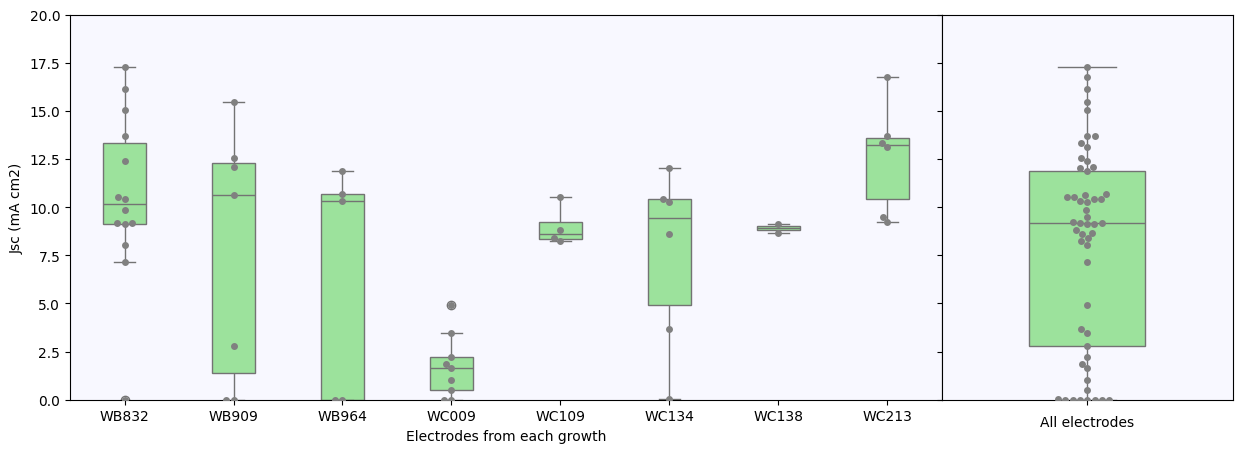

In [53]:
# Compare short circuit currents between each growth with that for all growths together

fig, ax = plt.subplots(nrows=1, ncols=2, dpi=100, sharey=True, figsize=(15,5), gridspec_kw={'width_ratios': [3, 1]})

# why do the axes here iterate over the row as well?
for a in ax:
    print(a)
#print(ax[0])
sns.boxplot(y='Jsc (mA/cm2)', data=df_all, x='Growth', width = 0.4, ax=ax[0], color = 'lightgreen', zorder=2)
sns.swarmplot(y='Jsc (mA/cm2)', data=df_all, x='Growth', ax=ax[0], size=5, color='gray')

sns.boxplot(y='Jsc (mA/cm2)', data=df_all, width=0.4, ax=ax[1], color='lightgreen', zorder=2)
sns.swarmplot(y='Jsc (mA/cm2)', data=df_all, ax=ax[1], color='gray')

ax[0].set_ylabel('Jsc (mA cm2)')
ax[0].set_xlabel('Electrodes from each growth')
ax[1].set_ylabel('Jsc (mA/cm2)')
ax[1].set_xlabel('All electrodes')

ax[0].set_ylim(0, 20); ax[1].set_ylim(0, 20)

for ax in ax.flat:
    ax.set_facecolor('ghostwhite')
fig.subplots_adjust(wspace=0.0, hspace=0.1)

plt.show()

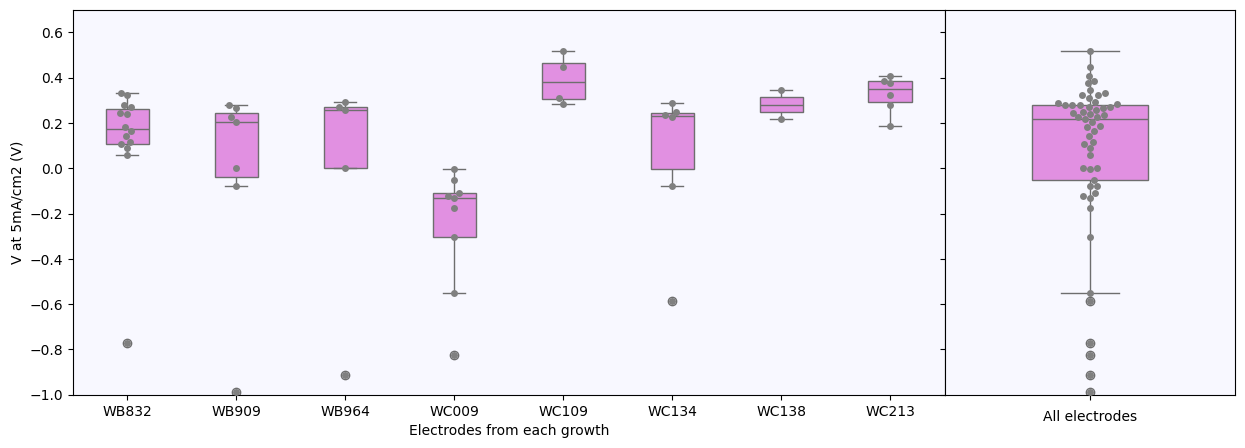

In [86]:
# Compare 5mA/cm2 potential for each growth and all growths

fig, ax = plt.subplots(nrows=1, ncols=2, dpi=100, sharey=True, figsize=(15,5), gridspec_kw={'width_ratios': [3, 1]})

sns.boxplot(y='V_5mA (V)', data=df_all, x='Growth', width = 0.4, ax=ax[0], color = 'violet', zorder=2)
sns.swarmplot(y='V_5mA (V)', data=df_all, x='Growth', ax=ax[0], size=5, color='gray')

sns.boxplot(y='V_5mA (V)', data=df_all, width=0.4, ax=ax[1], color='violet', zorder=2)
sns.swarmplot(y='V_5mA (V)', data=df_all, ax=ax[1], color='gray')

ax[0].set_ylabel('V at 5mA/cm2 (V)')
ax[0].set_xlabel('Electrodes from each growth')
ax[1].set_ylabel('V at 5mA/cm2 (V)')
ax[1].set_xlabel('All electrodes')
#ax[2].set_ylabel('V at 5mA/cm2 (V)')

ax[0].set_ylim(-1, 0.5); ax[1].set_ylim(-1, 0.7)

for ax in ax.flat:
    ax.set_facecolor('ghostwhite')
fig.subplots_adjust(wspace=0.0, hspace=0.1)

plt.show()

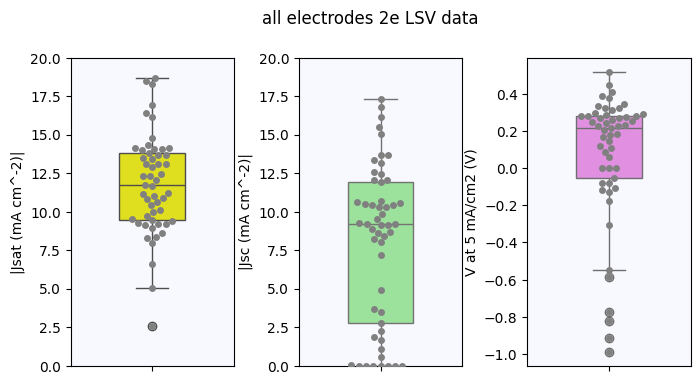


current density at short circuit vs. Ir/IrOx CE (mA/cm2):
median:   9.16
mean:     8.01
std dev:  5.21


In [79]:
# Now graph Jsat, Jsc, and 5 mA potential for all the electrodes
#use a dataframe to store results

## there were strange deprecation errors ignore them
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

sample =  []
Jsat = []
Jzero = []
V_5mA = []

for dic in exp_list:
    sample.append(dic['sample'])
    Jsat.append(np.abs(dic['Jsat (mA/cm2)']))
    Jzero.append(np.abs(dic['zero bias']))
    V_5mA.append(float(dic['5 mA potential']))

# Use a dictionary to associate the lists with the column headers
df_JWA = pd.DataFrame({'sample': sample,
                       'Jsat (mA/cm2)': Jsat,
                       'Jzero': Jzero,
                       'V_5mA': V_5mA}) 

# Fancy, write the samples in the title
temp_str = '  '.join(exp['sample'] for exp in exp_list)

fig, ax = plt.subplots(1,3, dpi=100, figsize=(8,4))
fig.suptitle('all electrodes 2e LSV data', y = 1.0)
#fig.suptitle('OA LSV data\n'
#             f'Samples: {temp_str}', y=1.0)

sns.boxplot(y='Jsat (mA/cm2)', data=df_all, width=0.4, ax=ax[0], color='yellow', zorder=2)
sns.swarmplot(y='Jsat (mA/cm2)', data=df_all, ax=ax[0], color='gray')


#sns.boxplot(y='Jsat (mA/cm2)', data=df_all, x='growth')

sns.boxplot(y="Jsc (mA/cm2)", data=df_all, width=0.4, ax=ax[1], color='lightgreen', zorder=2)
sns.swarmplot(y="Jsc (mA/cm2)", data=df_all, ax=ax[1], color='gray')

sns.boxplot(y="V_5mA (V)", data=df_all, width=0.4, ax=ax[2], color='violet', zorder=2)
sns.swarmplot(y="V_5mA (V)", data=df_all, ax=ax[2], color='gray')

ax[0].set_ylabel('|Jsat (mA cm^-2)|')
ax[1].set_ylabel('|Jsc (mA cm^-2)|')
ax[2].set_ylabel('V at 5 mA/cm2 (V)')

ax[0].set_ylim(0, 20); ax[1].set_ylim(0, 20) 


for ax in ax.flat:
    ax.set_facecolor('ghostwhite')

fig.subplots_adjust(wspace=0.4, hspace=0.1)

plt.show()

# Statistics
print('\ncurrent density at short circuit vs. Ir/IrOx CE (mA/cm2):')
print(f'median:  {df_all["Jsc (mA/cm2)"].median():>5.2f}')
print(f'mean:    {df_all["Jsc (mA/cm2)"].mean():>5.2f}')
print(f'std dev: {df_all["Jsc (mA/cm2)"].std():>5.2f}')

In [46]:
# Compare with Jsat, Jsc, and 5 mA potential for individual growths

## there were strange deprecation errors ignore them
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

growth = []
sample =  []
Jsat = []
Jzero = []
V_5mA = []

for dic in exp_list:
    growth.append(dic['growth'])
    sample.append(dic['sample'])
    Jsat.append(np.abs(dic['Jsat (mA/cm2)']))
    Jzero.append(np.abs(dic['zero bias']))
    V_5mA.append(float(dic['5 mA potential']))

# Use a dictionary to associate the lists with the column headers
df_OA = pd.DataFrame({'growth': growth, 
                      'sample': sample,
                       'Jsat (mA/cm2)': Jsat,
                       'Jzero': Jzero,
                       'V_5mA': V_5mA}) 

#first_df = df[df['J (mA/cm2)']<-5]
temp_df = df_OA[df_OA['growth'] == 'WB832']

df_OA.head()
temp_df



,growth,sample,Jsat (mA/cm2),Jzero,V_5mA
0,WB832,WB832-C1,16.157954,9.104689,0.106404
1,WB832,WB832-C2,8.573917,0.000000,-0.773122
2,WB832,WB832-C3,13.652918,7.169919,0.057431
3,WB832,WB832-C4,14.090213,9.204426,0.116999
4,WB832,WB832-C5,13.410872,10.437638,0.179965
5,WB832,WB832-C6,13.803464,9.862762,0.142985
6,WB832,WB832-C7,13.112378,10.556487,0.166372
7,WB832,WB832-C8,12.873657,8.012504,0.088714
8,WB832,WB832-C9,14.010306,13.677530,0.321288
9,WB832,WB832-NREL2,18.260145,17.292124,0.331283


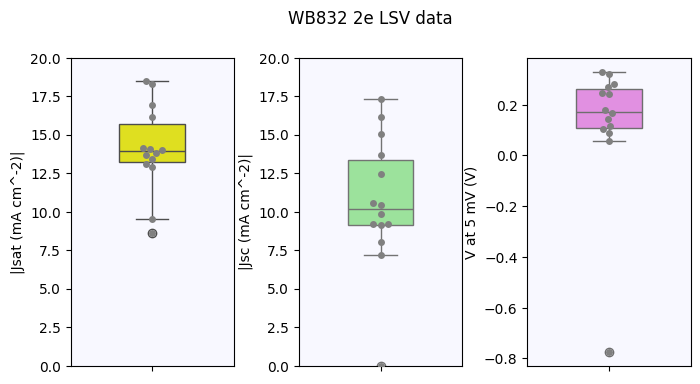

J at 0 vs CE (mA/cm2)
median:  10.15
mean:    10.58
std dev:  4.35


In [47]:


# Fancy, write the samples in the title
temp_str = '  '.join(exp['sample'] for exp in exp_list)

fig, ax = plt.subplots(1,3, dpi=100, figsize=(8,4))
fig.suptitle('WB832 2e LSV data', y = 1.0)
#fig.suptitle('OA LSV data\n'
#             f'Samples: {temp_str}', y=1.0)

sns.boxplot(y='Jsat (mA/cm2)', data=temp_df, width=0.4, ax=ax[0], color='yellow', zorder=2)
sns.swarmplot(y='Jsat (mA/cm2)', data=temp_df, ax=ax[0], color='gray')

sns.boxplot(y="Jzero", data=temp_df, width=0.4, ax=ax[1], color='lightgreen', zorder=2)
sns.swarmplot(y="Jzero", data=temp_df, ax=ax[1], color='gray')

sns.boxplot(y="V_5mA", data=temp_df, width=0.4, ax=ax[2], color='violet', zorder=2)
sns.swarmplot(y="V_5mA", data=temp_df, ax=ax[2], color='gray')

ax[0].set_ylabel('|Jsat (mA cm^-2)|')
ax[1].set_ylabel('|Jsc (mA cm^-2)|')
ax[2].set_ylabel('V at 5 mV (V)')

ax[0].set_ylim(0, 20); ax[1].set_ylim(0, 20) 


for ax in ax.flat:
    ax.set_facecolor('ghostwhite')

fig.subplots_adjust(wspace=0.4, hspace=0.1)

plt.show()

# Statistics
print('J at 0 vs CE (mA/cm2)')
print(f'median:  {temp_df["Jzero"].median():>5.2f}')
print(f'mean:    {temp_df["Jzero"].mean():>5.2f}')
print(f'std dev: {temp_df["Jzero"].std():>5.2f}')